In [37]:
import pandas as pd
import numpy as np

In [38]:
df_prescriptions = pd.read_csv('./data/all_prescriptions.csv')
print(df_prescriptions.shape)
df_prescriptions.head()

(15806, 3)


,example_id,prescription,is_train
0,4,CIP,1
1,31,NIT,0
2,34,SXT,1
3,36,NIT,0
4,48,LVX,1


In [39]:
df_labels = pd.read_csv('./data/all_uti_resist_labels.csv')
print(df_labels.shape)
df_labels.head()

(116902, 7)


,example_id,NIT,SXT,CIP,LVX,is_train,uncomplicated
0,0,0.0,0.0,0.0,0.0,0,0
1,1,0.0,0.0,0.0,0.0,1,0
2,2,0.0,0.0,1.0,1.0,1,0
3,3,0.0,0.0,0.0,0.0,1,0
4,4,0.0,0.0,0.0,0.0,1,1


In [40]:
### Join prescriptions to labels
df_prescriptions = (df_prescriptions
    .merge(df_labels, how='inner', on=['example_id', 'is_train'])
)
print(df_prescriptions.shape)

(15806, 8)


In [41]:
# prescriptions only come from uncomplicated uti
df_prescriptions.groupby('uncomplicated').count()

,example_id,prescription,is_train,NIT,SXT,CIP,LVX
uncomplicated,,,,,,,
1,15806,15806,15806,15806,15806,15806,15806


In [45]:
def get_dr_miss_rate(df):
    """
    Given dataframe with prescription and resistance labels,
    will return the fraction of observations not covered by their prescriptions
    """
    
    df = (df
        .assign(missed=lambda x: [x[p][i] for i, p in enumerate(x.prescription.values)])
        .query("is_train == 0", engine='python')
    )
    num_missed = df['missed'].sum()
    frac_missed = float(num_missed) / len(df)
    return frac_missed

get_dr_miss_rate(df_prescriptions)
    

0.11925907130170008

### Randomly shuffle prescription column to build null distribution of miss rate

100%|██████████| 1000/1000 [01:28<00:00, 11.27it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbcd72ed510>]],
      dtype=object)

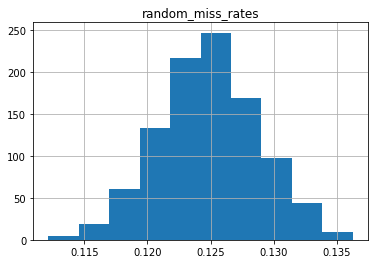

In [46]:
from tqdm import tqdm
import pdb
random_miss_rates = []
for i in tqdm(range(1000)):
    df_prescriptions['prescription'] = df_prescriptions['prescription'].sample(frac=1.0).values
    random_miss_rates.append(get_dr_miss_rate(df_prescriptions))

df_miss = pd.DataFrame(data={
    'random_miss_rates' : random_miss_rates
})

df_miss.hist()

In [47]:
# Get a pvalues
actual_miss_rate = 0.11925907130170008
num_fewer = len([r for r in random_miss_rates if r <= actual_miss_rate])
pvalue = float(num_fewer)/1000
print(pvalue)

0.084


In [48]:
np.mean(random_miss_rates)

0.1248442019791931